In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from textwrap import fill
from synergy_dataset import Dataset, iter_datasets
from buscarpy import calculate_h0
from fastlite import *
from fastcore.utils import *
from fastcore.net import urlsave
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc

In [2]:
%%sh
bash sync.sh

In [3]:
dbpath = 'output_data/experiments.sql'
con = sqlite3.connect(dbpath)
rdf = pd.read_sql_query('SELECT * FROM reviews',con)
rdf

,review_id,review_name,n_records,prevalence
0,0,Appenzeller-Herzog_2019,2873,0.009050
1,1,Bos_2018,4878,0.002050
2,2,Brouwer_2019,38114,0.001627
3,3,Chou_2003,1908,0.007862
4,4,Chou_2004,1630,0.005521
5,5,Donners_2021,258,0.058140
6,6,Hall_2012,8793,0.011828
7,7,Jeyaraman_2020,1175,0.081702
8,8,Leenaars_2019,5812,0.002925
9,9,Leenaars_2020,7216,0.080793


In [4]:
d_map = {}
max_len = 10
for d in iter_datasets():
    ti = d.metadata['publication']['title']
    d_map[d.name] = fill(ti, width=80)
d_map

{'Appenzeller-Herzog_2019': 'Comparative effectiveness of common therapies for Wilson disease: A systematic\nreview and meta‐analysis of controlled studies',
 'Bos_2018': 'Cerebral small vessel disease and the risk of dementia: A systematic review and\nmeta‐analysis of population‐based evidence',
 'Brouwer_2019': 'Psychological theories of depressive relapse and recurrence: A systematic review\nand meta-analysis of prospective studies',
 'Chou_2003': 'Comparative efficacy and safety of long-acting oral opioids for chronic non-\ncancer pain: a systematic review',
 'Chou_2004': 'Comparative efficacy and safety of skeletal muscle relaxants for spasticity and\nmusculoskeletal conditions: a systematic review',
 'Donners_2021': 'Pharmacokinetics and Associated Efficacy of Emicizumab in Humans: A Systematic\nReview',
 'Hall_2012': 'A Systematic Literature Review on Fault Prediction Performance in Software\nEngineering',
 'Jeyaraman_2020': 'Does the Source of Mesenchymal Stem Cell Have an Effe

In [5]:
def proc_llm_df(llm_df):
    llm_df['pred'] = llm_df['py'] - llm_df['pn']    
    llm_df['pmass'] = llm_df['py'] + llm_df['pn']
    llm_df['alt_pred'] = llm_df['pred'] * llm_df['pmass']
    # Sort LLM results in descending order of pred, the order we would screen them
    llm_df = llm_df.sort_values('pred', ascending=False)
    # Calculate recall, the order, and x, the proportion of documents screened
    
    llm_df['recall'] = llm_df['y'].cumsum() / llm_df['y'].sum()
    llm_df['order'] = np.arange(llm_df.shape[0])
    llm_df['x'] = llm_df['order'] / llm_df.shape[0] 
    return llm_df

In [6]:
models = [
    "meta-llama/Meta-Llama-3.1-70B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    # "meta-llama/Llama-2-13b-chat",
    # "meta-llama/Llama-2-70b-chat"
]

In [7]:
model = models[1]
review_name = 'Appenzeller-Herzog_2019'
llm_df = pq.read_table(
    f'output_data/llm_preds',
    filters=[
        ('review', '=', review_name),
        ('model', '=', model)
    ]
).to_pandas().dropna()
llm_df

,y,py,pn,review,model
openalex_id,,,,,
https://openalex.org/W2402226166,0,0.019474,0.969495,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2416808666,0,0.592207,0.388322,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2060266518,0,0.147067,0.816616,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2412464989,0,0.077784,0.906210,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W66518910,0,0.190055,0.787558,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
...,...,...,...,...,...
https://openalex.org/W2415222463,0,0.893291,0.989694,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2078451344,0,-0.431833,0.971101,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct
https://openalex.org/W2413863058,0,-0.691833,0.918335,Appenzeller-Herzog_2019,meta-llama/Meta-Llama-3.1-8B-Instruct


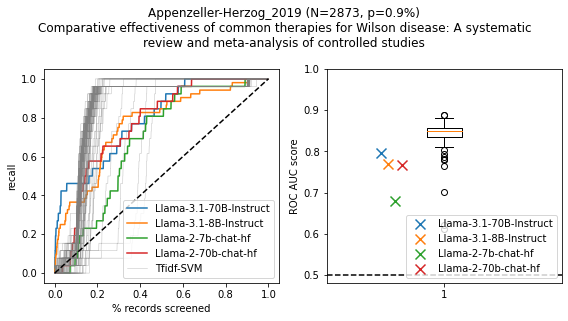

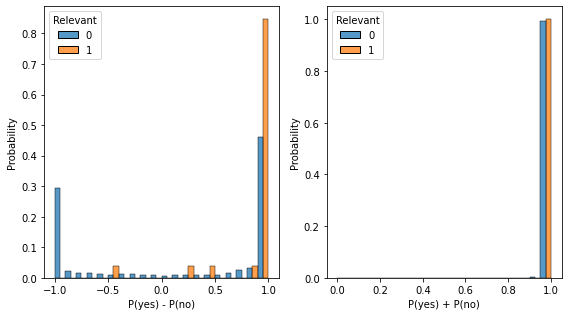

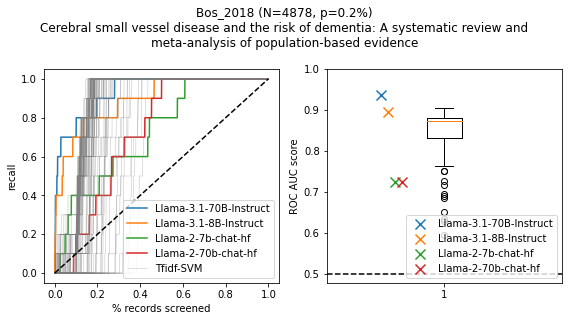

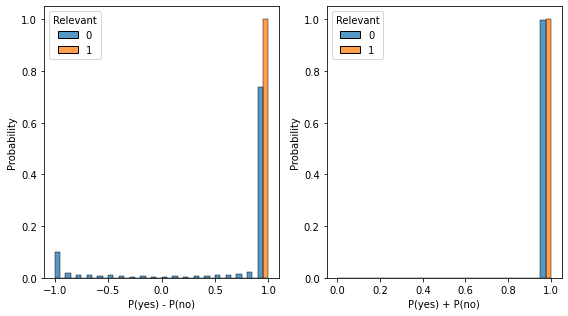

/tmp/ipykernel_673119/2554461916.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_673119/2554461916.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/tmp/ipykernel_673119/2554461916.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


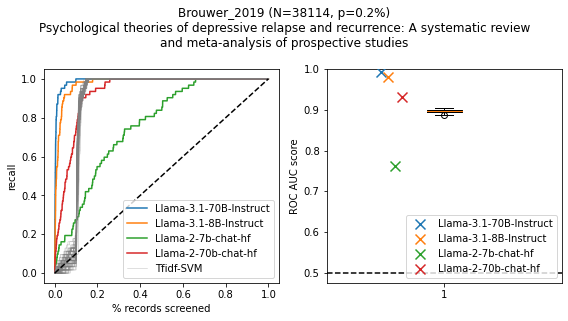

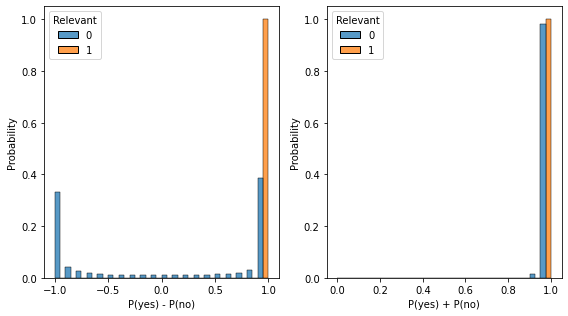

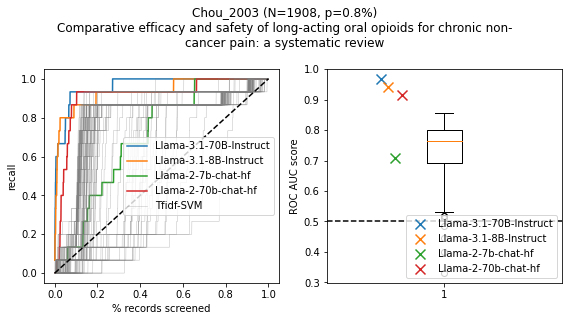

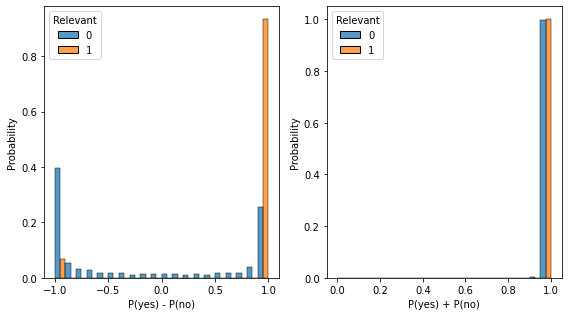

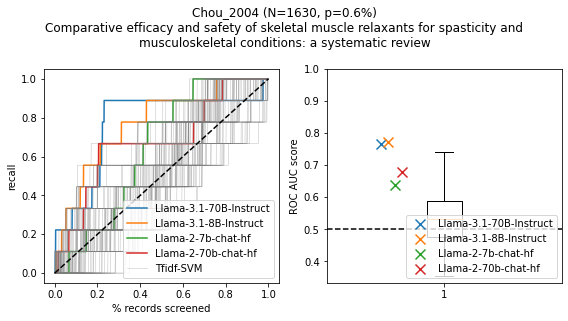

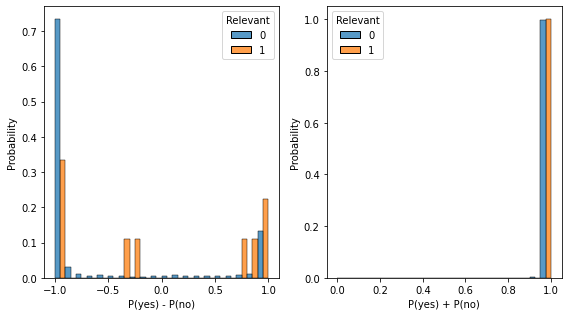

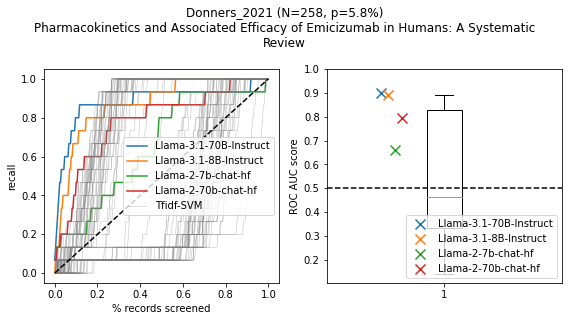

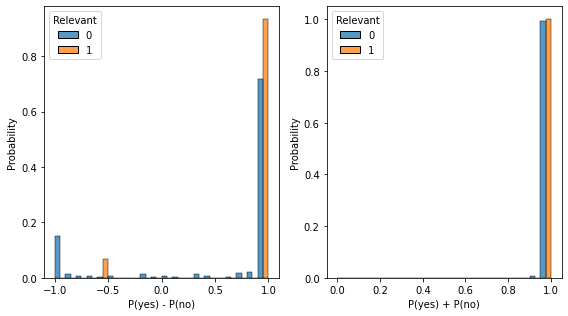

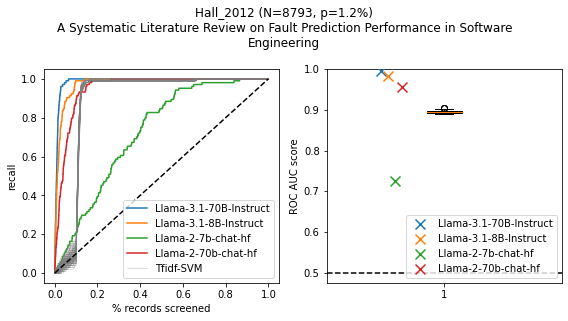

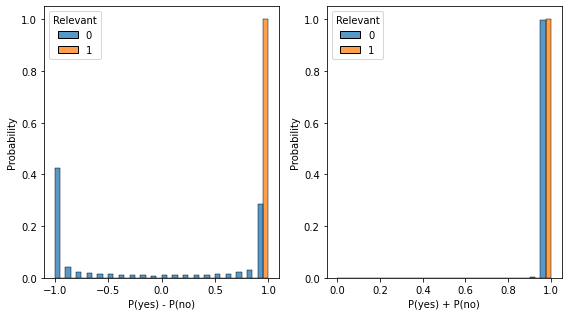

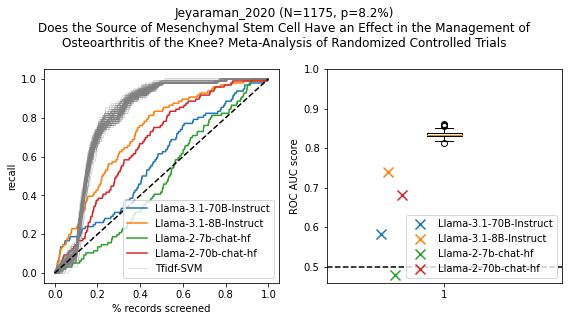

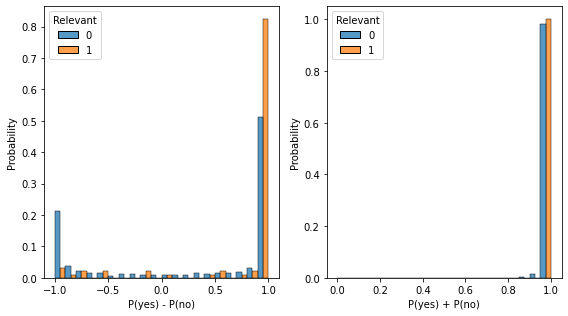

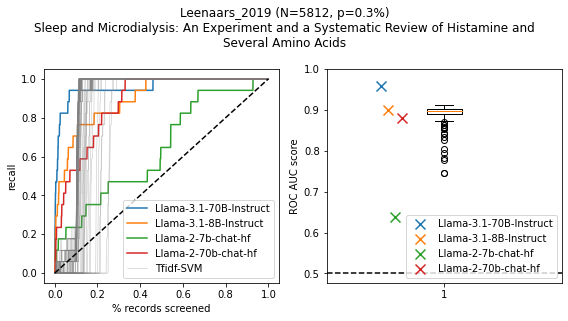

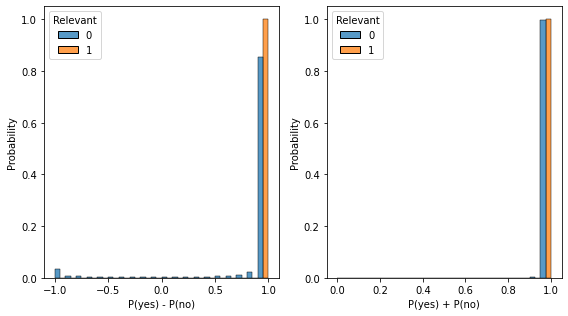

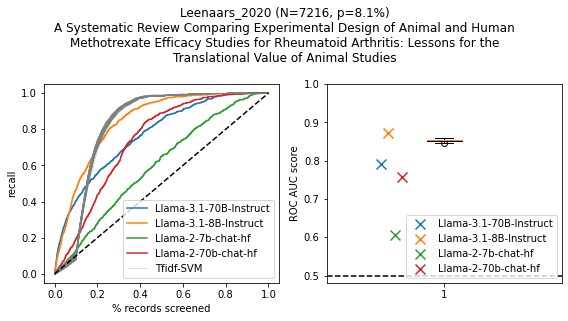

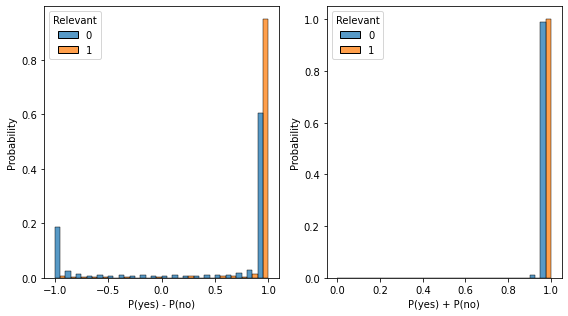

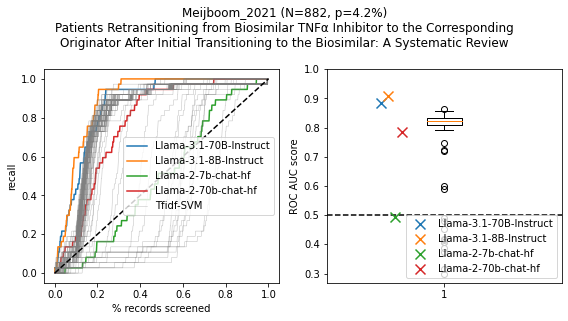

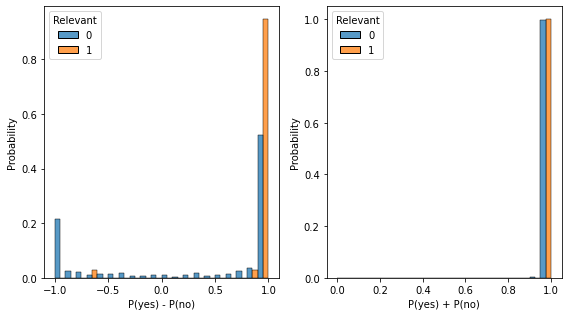

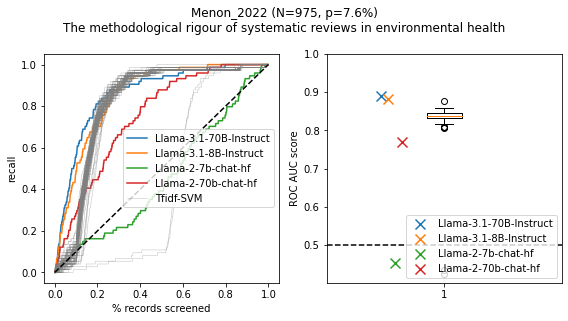

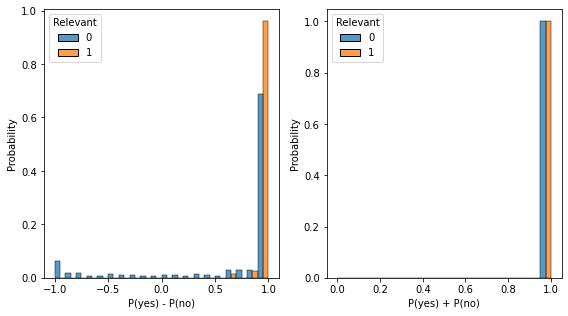

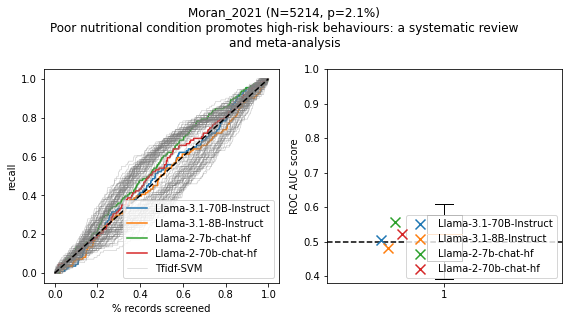

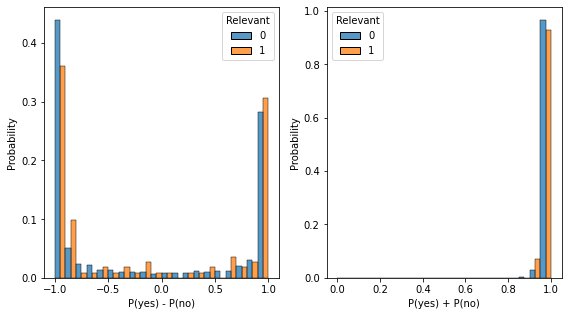

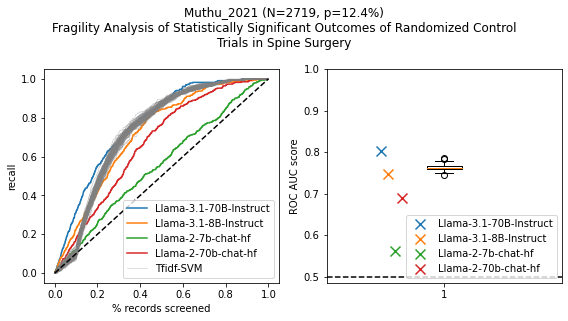

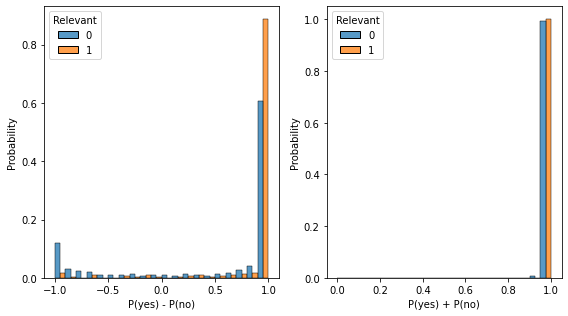

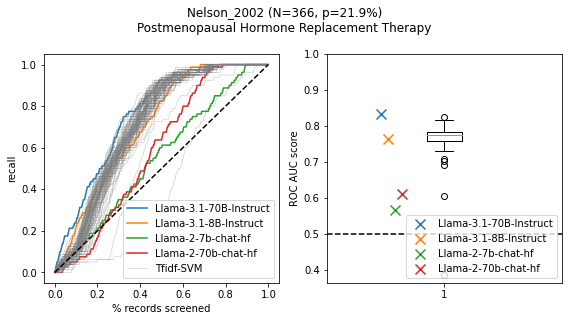

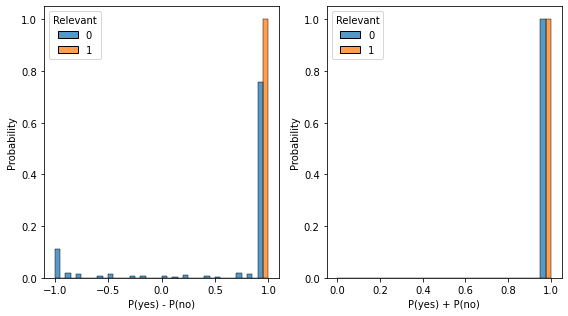

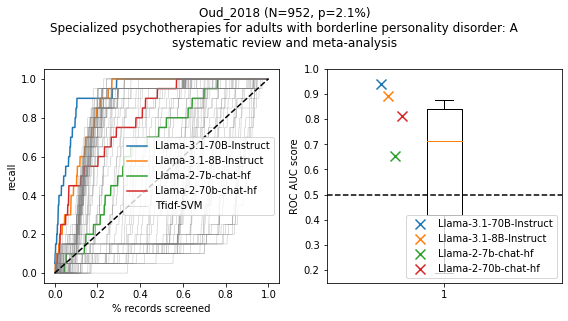

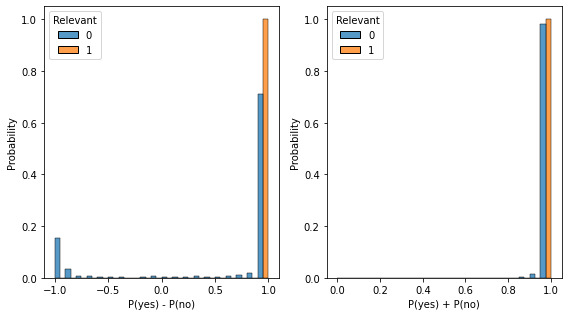

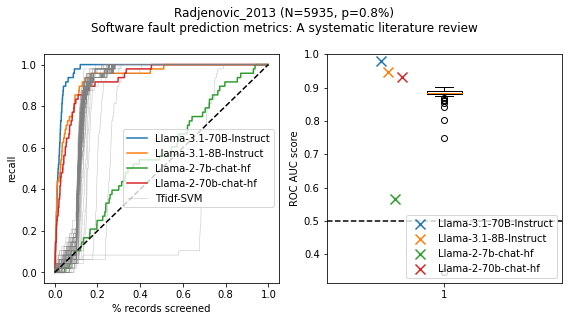

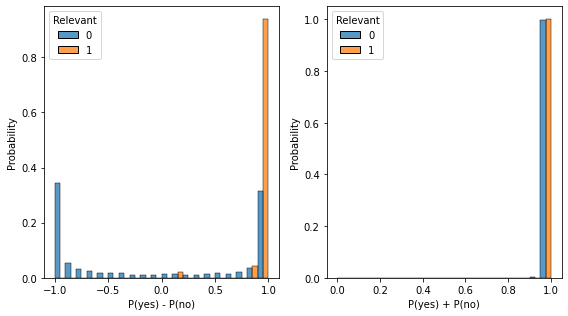

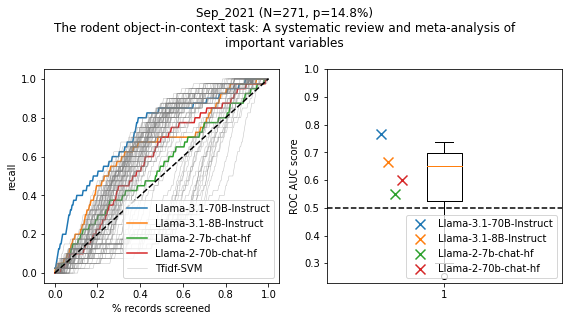

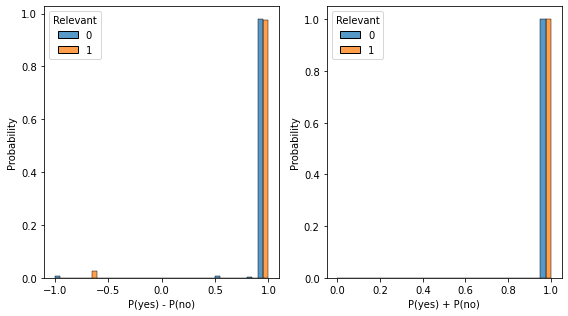

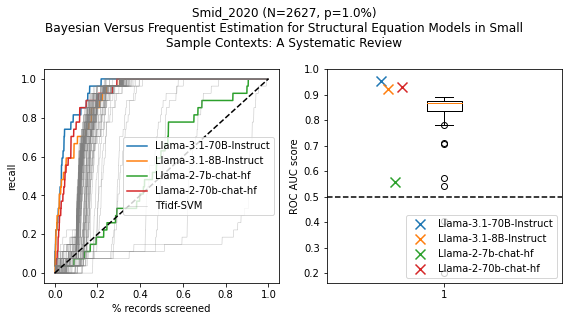

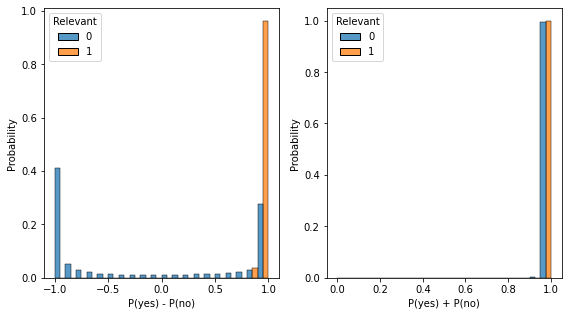

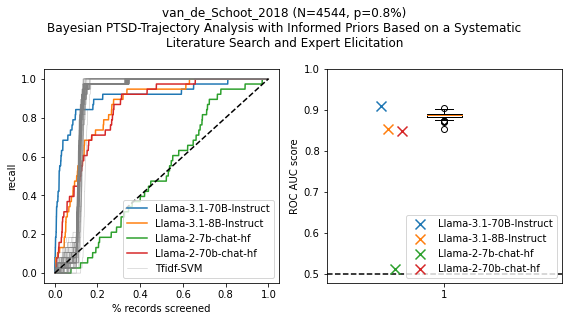

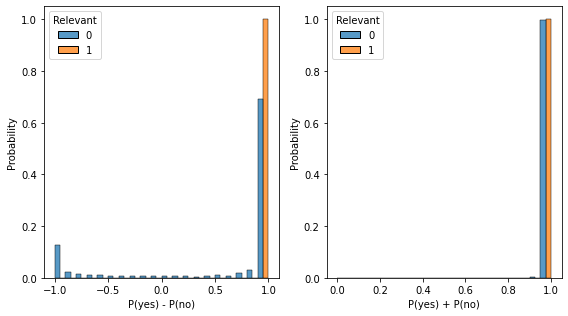

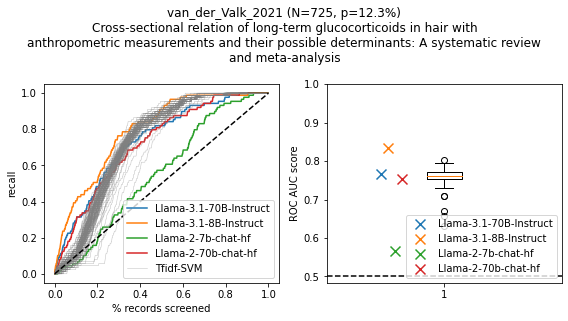

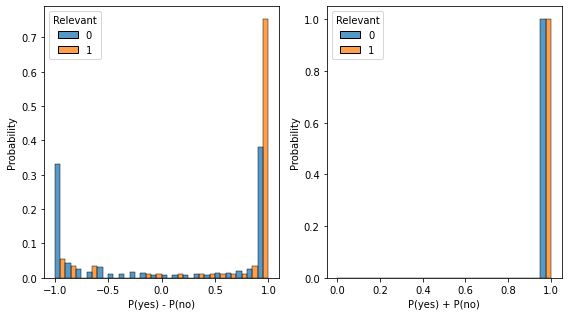

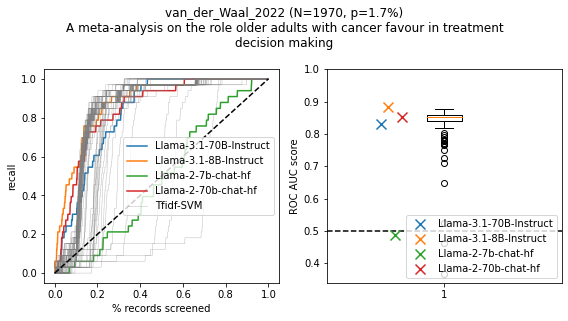

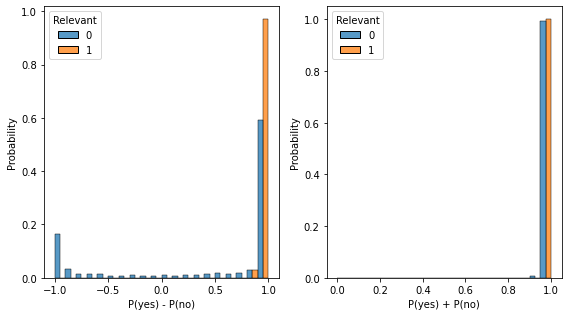

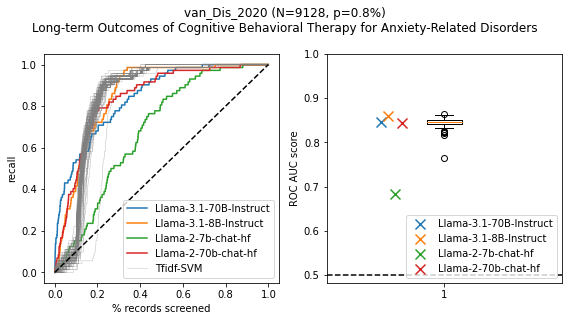

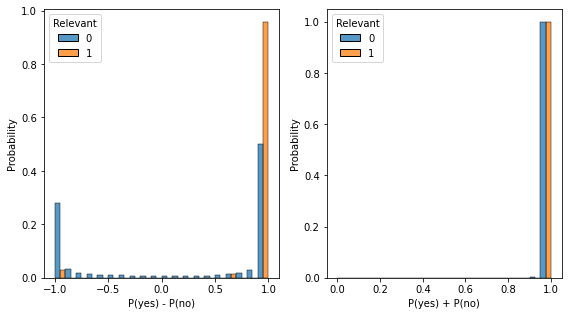

/tmp/ipykernel_673119/2554461916.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_673119/2554461916.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/tmp/ipykernel_673119/2554461916.py:90: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


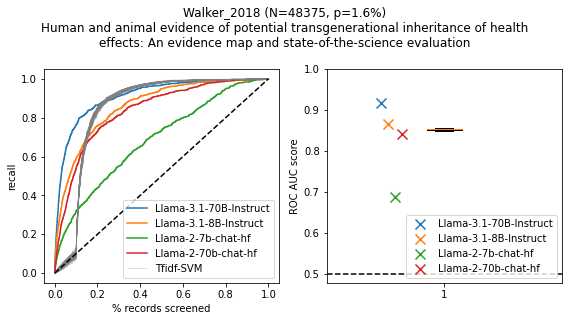

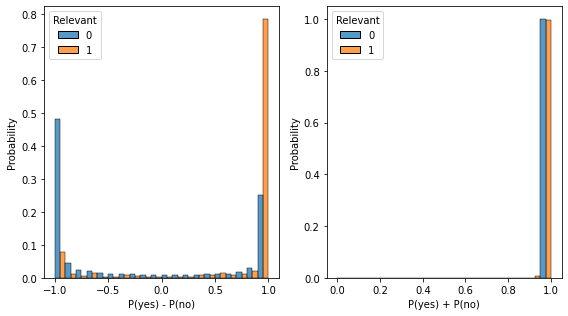

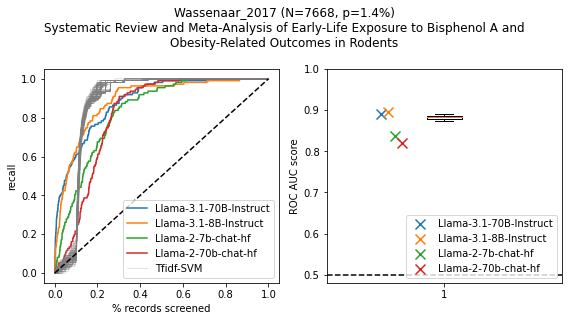

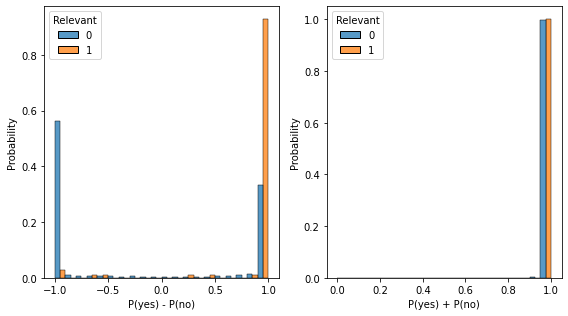

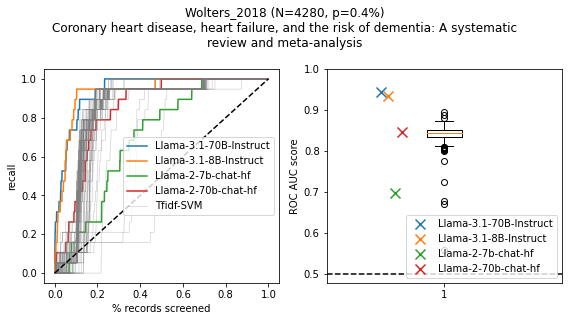

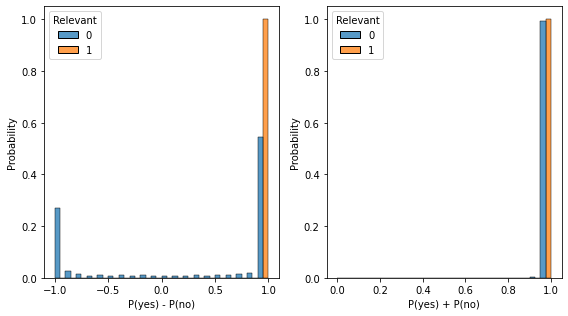

In [8]:
svm_auc_scores = []
llm_auc_scores = []

reviews = []


def order_score(x):
    return 1-(x-x.min())/(x.max()-x.min())

for r, row in rdf.iterrows():
    review_name = row['review_name']
    table = pq.read_table(
        'output_data/ordered_records', 
        filters=[('review_id', '=', row['review_id'])]
    )
    
    # Setup graph with two panels
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))
    ax = axs[0]
    
    llm_aucs = []
    for model in models:
        llm_res = pq.read_table(
            f'output_data/llm_preds',
            filters=[
                ('review', '=', review_name),
                ('model', '=', model)
            ]
        ).to_pandas().dropna()

        if llm_res.shape[0] == 0:
            llm_aucs.append(None)
            continue

        llm_df = proc_llm_df(llm_res)

        # Plot LLM recall curve
        ax.plot(llm_df['x'], llm_df['recall'], label=model.split('/')[1].replace('Meta-',''))
        # Calculate LLM ROC AUC score and plot it with an x
        auc = roc_auc_score(llm_df['y'], llm_df['pred'])
        llm_aucs.append(auc)
    llm_auc_scores.append(llm_aucs)
            
    if llm_df.shape[0]==0:
        continue

    study_title = f'{review_name} (N={llm_df.shape[0]}, p={llm_df["y"].sum()/llm_df.shape[0]:.1%})'
    reviews.append(study_title)
    plt.suptitle(study_title + '\n' + d_map[review_name])

    #  Go through each active learning run, and plot progress
    aucs = []

    for i, (name, group) in enumerate(table.to_pandas().groupby('run_id', observed=False)):
        group = group.sort_values('screened_order').reset_index()
        group['score'] = order_score(group['screened_order'])
        group['x'] = group['screened_order'] / group.shape[0]
        group['recall'] = group['relevant'].cumsum()/group['relevant'].sum()
        aucs.append(roc_auc_score(group['relevant'],group['score']))
        ax.plot(group['x'], group['recall'], color='grey',alpha=0.5,lw=0.5, label='Tfidf-SVM' if i==0 else None)
    svm_auc_scores.append(aucs)

    # Plot a diagonal line showing random chance
    ax.plot([0,1],[0,1], color='black',ls='--')

    ax.legend()

    # Show the distribution of ROC AUC scores
    axs[1].boxplot(aucs)
    axs[1].axhline(0.5, color='black', ls='--')
    
    j = 0
    for m, s in zip(models, llm_aucs):
        j+=1
        axs[1].scatter(
            0.7+j*0.03, s,     
            marker='x',
            s=100,
            zorder=50,
            label=m.split('/')[1].replace('Meta-','')
        )

    # Legend and axis labels
    axs[1].legend(loc='lower right')
    axs[0].set_xlabel('% records screened')
    axs[0].set_ylabel('recall')
    axs[1].set_ylim(ymax=1)
    axs[1].set_ylabel('ROC AUC score')
    plt.tight_layout()
    plt.savefig(f'figures/{review_name}.pdf', bbox_inches='tight')
    plt.show()

    # New plot for distribution of p scores
    fig, axs = plt.subplots(1,2, figsize=(8,4.5))

    # Distribution of p(Yes)-P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pred', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[0],
        binwidth=0.1, binrange=[-1,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[0].set_xlabel('P(yes) - P(no)')

    # Distribution of p(Yes)+P(no)
    g = sns.histplot(
        llm_df, hue='y', x='pmass', stat='probability', 
        multiple='dodge', common_norm=False, ax=axs[1],
        binwidth=0.05, binrange=[0,1], legend=True,
    )
    leg = g.axes.get_legend()
    leg.set_title('Relevant')
    axs[1].set_xlabel('P(yes) + P(no)')
    #plt.suptitle(study_title + '\n' + d_map[review])

    fig.tight_layout()
    plt.savefig(f'figures/{review_name}_p_distribution.pdf', bbox_inches='tight')
    plt.show()

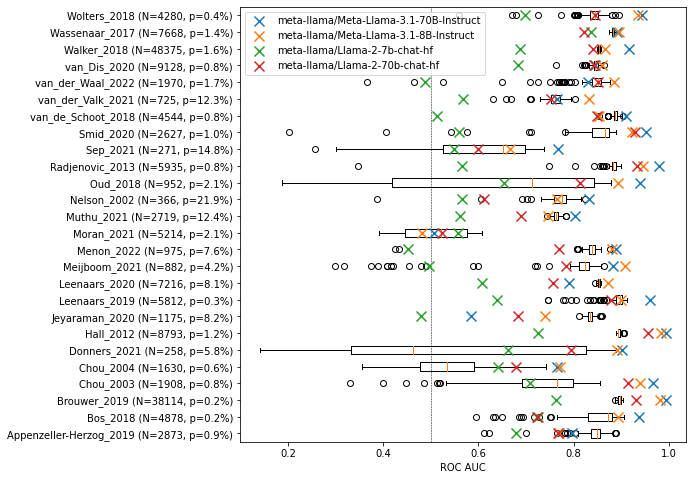

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

ax.boxplot(svm_auc_scores, vert=False)
#llm_auc_scores
ax.set_yticklabels(reviews)
for i, m in enumerate(models):
    scores = [x[i] for x in llm_auc_scores]
    ax.scatter(
        scores, 
        np.arange(len(scores))+1,
        marker='x',
        s=100,
        zorder=50,
        label=m
    )

ax.legend()
ax.axvline(0.5, lw=0.5, ls='--', color='black')
ax.set_xlabel('ROC AUC')
plt.savefig('figures/llm_svm_roc.pdf', bbox_inches='tight')
plt.show()

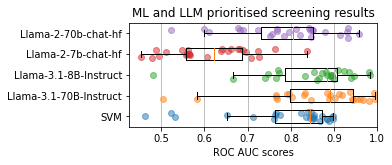

In [10]:
scaler = 1.5
fig, ax = plt.subplots(figsize=(3.7*scaler,1.6*scaler))
meds = [np.median(x) for x in svm_auc_scores]
valid_llm_auc_scores = [[y for y in x if y is not None] for x in np.array(llm_auc_scores).T]
ax.boxplot(
    [meds] + valid_llm_auc_scores,
    vert=False, widths=0.6, showfliers=False,
)
noise = (np.random.random(size=len(meds))-.5)/2
ax.scatter(
    meds, 1+noise,
    alpha=0.5
)

for i, scores in enumerate(valid_llm_auc_scores):
    noise = (np.random.random(size=len(scores))-.5)/2
    ax.scatter(
        scores, 2+i+noise,
        alpha=0.5
    )
    
model_names = [x.split('/')[1].replace('Meta-','') for x in models]
ax.set_yticklabels(['SVM']+model_names)

ax.set_xlabel('ROC AUC scores')
ax.set_title('ML and LLM prioritised screening results')
ax.grid(axis='x')
ax.set_xlim(xmax=1)

fig.tight_layout()
    
plt.savefig('figures/macro_comparison.pdf', bbox_inches='tight')

In [11]:
model = models[1]
review_name = 'Brouwer_2019'
llm_df = pq.read_table(
    f'output_data/llm_preds',
    filters=[
        ('review', '=', review_name),
        ('model', '=', model)
    ]
).to_pandas()
llm_df = proc_llm_df(llm_df)
llm_df

,y,py,pn,review,model,pred,pmass,alt_pred,recall,order,x
openalex_id,,,,,,,,,,,
https://openalex.org/W2535323633,1,0.996989,0.000662,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.996327,0.997650,0.993986,0.016129,0,0.000000
https://openalex.org/W2032916808,0,0.995154,0.001351,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993803,0.996505,0.990330,0.016129,1,0.000026
https://openalex.org/W2613037413,0,0.994973,0.001435,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993538,0.996408,0.989969,0.016129,2,0.000052
https://openalex.org/W2896320919,0,0.995438,0.001995,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.993443,0.997433,0.990893,0.016129,3,0.000079
https://openalex.org/W2738442045,0,0.994463,0.001740,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,0.992723,0.996203,0.988954,0.016129,4,0.000105
...,...,...,...,...,...,...,...,...,...,...,...
https://openalex.org/W1569802529,0,0.000272,0.997859,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997587,0.998131,-0.995722,1.000000,38109,0.999869
https://openalex.org/W1577452758,0,0.000332,0.998106,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997774,0.998437,-0.996215,1.000000,38110,0.999895
https://openalex.org/W1996690535,0,0.000245,0.998051,Brouwer_2019,meta-llama/Meta-Llama-3.1-8B-Instruct,-0.997806,0.998296,-0.996105,1.000000,38111,0.999921


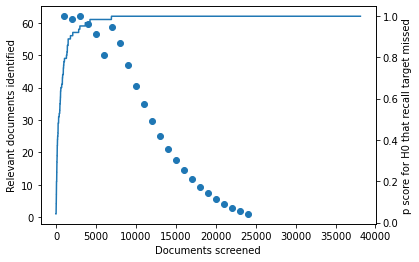

In [12]:
from buscarpy import retrospective_h0

y = llm_df.sort_values('py', ascending=False).reset_index(drop=True).y
h0 = retrospective_h0(y, llm_df.shape[0])

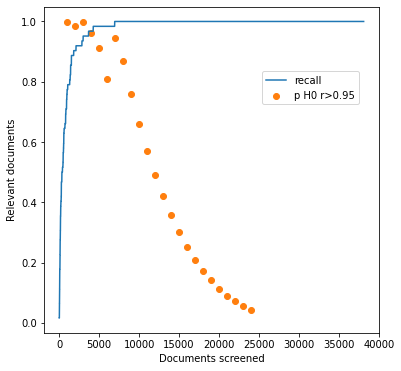

In [13]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(y.cumsum()/y.sum(), label='recall')

ax.set_ylabel('Relevant documents')



ax.scatter(h0['batch_sizes'], h0['p'], c='C1', label='p H0 r>0.95')

ax.legend(loc=(0.65,0.7))

ax.set_xlabel('Documents screened')

plt.savefig('figures/stopping.pdf', bbox_inches='tight')